# Comparison of created models and applying k-fold validation to the winner
This notebook takes all the models created in other notebooks and runs them on the same train and validation sets in order to determine the most accurate one.  After the winner is determined, it is trained again on the entire original training dataset and applied with the test set.  In addition, k-fold validation is applied the winner in order to compare the results with simple hold-out.

## Get the saved models from my Github repo

In [0]:
!wget  https://github.com/Stnslv/ML-Homeworks/blob/master/HW2/models/model_simple.h5?raw=true \
  -O model_simple.h5
  
!wget  https://github.com/Stnslv/ML-Homeworks/blob/master/HW2/models/model_dropout.h5?raw=true \
  -O model_dropout.h5

!wget  https://github.com/Stnslv/ML-Homeworks/blob/master/HW2/models/model_normalize.h5?raw=true \
  -O model_normalize.h5

--2019-04-05 01:57:04--  https://github.com/Stnslv/ML-Homeworks/blob/master/HW2/models/model_simple.h5?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Stnslv/ML-Homeworks/raw/master/HW2/models/model_simple.h5 [following]
--2019-04-05 01:57:05--  https://github.com/Stnslv/ML-Homeworks/raw/master/HW2/models/model_simple.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Stnslv/ML-Homeworks/master/HW2/models/model_simple.h5 [following]
--2019-04-05 01:57:05--  https://raw.githubusercontent.com/Stnslv/ML-Homeworks/master/HW2/models/model_simple.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercon

## Import statements and loading of the Cifar10 Dataset

In [0]:
from keras.datasets import cifar10
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

from google.colab import files

import numpy as np

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 20s 0us/step


## Initial data processing

In [0]:
# Data images/labels will be broken into the training and validation sets.
data_images = train_images_original / 255.0
test_images = test_images_original / 255.0

data_labels = train_labels_original
test_labels = test_labels_original

In [0]:
# We get the size of the entire data set and
# find how large the validation size needs to be.
data_size = len(data_images)
val_size = int(data_size * 0.2)

# Shuffle the data set and its labels.
shuffled_i = np.random.permutation(data_size)
data_images = data_images[shuffled_i]
data_labels = data_labels[shuffled_i]

# Get the first val_size of the data as validation,
# and use the rest for training.
val_images = data_images[:val_size]
train_images = data_images[val_size:]

val_labels = data_labels[:val_size]
train_labels = data_labels[val_size:]

## Process data for data augmentation model

In [0]:
# Declare the batch size of the data generators, 
# as well the training and validation steps
# for when the model is fitted.
batches = 128 
train_steps = int(40000/batches)
val_steps = int(10000/batches)

# This data augmenter for the training set
# rotates, horizontally/vertically shifts,
# shears, and flips the image.
train_datagen = ImageDataGenerator(
    rescale=1.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Pass in the train data to create generator.
train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=batches,
)

# The validation data stays the same.
validation_datagen = ImageDataGenerator(rescale=1.)

validation_generator = validation_datagen.flow(
    val_images,
    val_labels,
    batch_size=batches,
)


## Load the models and save their initial weights
The reason for saving the weights is that the the winning model needs to be reinitialized to be trained again on the entire original train set, and also reinitialized on every fold in k-fold validation, so loading the models with their original untrained weights is the quickest way to reinitialize them.  The weights for every model are saved because at this stage I do not know which model is the best.

In [0]:
model_simple = load_model('model_simple.h5')
model_simple.save_weights('weights_simple.h5')

model_dropout = load_model('model_dropout.h5')
model_dropout.save_weights('weights_dropout.h5')

model_drop_aug = load_model('model_dropout.h5')
model_drop_aug.save_weights('weights_drop_aug.h5')

model_norm = load_model('model_normalize.h5')
model_norm.save_weights('weights_norm.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Fit the simple model on the training and validation sets

In [0]:
history_simple = model_simple.fit(train_images, 
                                  train_labels, 
                                  epochs=50,  
                                  validation_data=(val_images, val_labels))

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 22s 562us/step - loss: 1.7683 - acc: 0.3556 - val_loss: 1.5413 - val_acc: 0.4400
Epoch 2/50
40000/40000 [==============================] - 19s 486us/step - loss: 1.4448 - acc: 0.4824 - val_loss: 1.4587 - val_acc: 0.4883
Epoch 3/50
40000/40000 [==============================] - 19s 486us/step - loss: 1.2923 - acc: 0.5439 - val_loss: 1.2948 - val_acc: 0.5408
Epoch 4/50
40000/40000 [==============================] - 19s 487us/step - loss: 1.1807 - acc: 0.5864 - val_loss: 1.1989 - val_acc: 0.5719
Epoch 5/50
40000/40000 [==============================] - 19s 482us/step - loss: 1.0936 - acc: 0.6187 - val_loss: 1.0996 - val_acc: 0.6139
Epoch 6/50
40000/40000 [==============================] - 19s 482us/step - loss: 1.0220 - acc: 0.6466 - val_loss: 1.0275 - val_acc: 0.6418
Epoch 7/50
40000/40000 [==============================] - 19s 484us/

## Fit the dropout model with the training and validation sets

In [0]:
history_drop = model_dropout.fit(train_images, 
                              train_labels, 
                              epochs=50,  
                              validation_data=(val_images, val_labels))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 24s 612us/step - loss: 1.8116 - acc: 0.3305 - val_loss: 1.5427 - val_acc: 0.4444
Epoch 2/50
40000/40000 [==============================] - 24s 593us/step - loss: 1.4663 - acc: 0.4667 - val_loss: 1.2925 - val_acc: 0.5393
Epoch 3/50
40000/40000 [==============================] - 23s 586us/step - loss: 1.3145 - acc: 0.5272 - val_loss: 1.1986 - val_acc: 0.5747
Epoch 4/50
40000/40000 [==============================] - 24s 589us/step - loss: 1.2165 - acc: 0.5687 - val_loss: 1.1509 - val_acc: 0.5924
Epoch 5/50
40000/40000 [==============================] - 24s 588us/step - loss: 1.1374 - acc: 0.5985 - val_loss: 1.0406 - val_acc: 0.6392
Epoch 6/50
40000/40000 [==============================] - 24s 590us/step - loss: 1.0737 - acc: 0.6215 - val_loss: 0.9798 - val_acc: 0.6642
Epoch 7/50
40000/40000 [==============================] - 23s 587us/step - loss: 1.0282 - acc: 0.6369 - val_loss: 0.

## Fit the dropout model with added data augmentation

In [0]:
history_drop_aug = model_drop_aug.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=val_steps
)

Epoch 1/50
312/312 [==============================] - 27s 88ms/step - loss: 2.0659 - acc: 0.2236 - val_loss: 1.8523 - val_acc: 0.3263
Epoch 2/50
312/312 [==============================] - 26s 85ms/step - loss: 1.8845 - acc: 0.3031 - val_loss: 1.8460 - val_acc: 0.3220
Epoch 3/50
312/312 [==============================] - 27s 85ms/step - loss: 1.8034 - acc: 0.3355 - val_loss: 1.7134 - val_acc: 0.3886
Epoch 4/50
312/312 [==============================] - 26s 85ms/step - loss: 1.7436 - acc: 0.3591 - val_loss: 1.5436 - val_acc: 0.4436
Epoch 5/50
312/312 [==============================] - 27s 87ms/step - loss: 1.6867 - acc: 0.3854 - val_loss: 1.5111 - val_acc: 0.4630
Epoch 6/50
312/312 [==============================] - 27s 87ms/step - loss: 1.6524 - acc: 0.4018 - val_loss: 1.4100 - val_acc: 0.4998
Epoch 7/50
312/312 [==============================] - 27s 87ms/step - loss: 1.6163 - acc: 0.4151 - val_loss: 1.4401 - val_acc: 0.4800
Epoch 8/50
312/312 [==============================] - 27s 87ms

## Fit the normalized model with the training and validation sets

In [0]:
history_norm = model_norm.fit(train_images, 
                              train_labels, 
                              epochs=50,  
                              validation_data=(val_images, val_labels))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 31s 766us/step - loss: 2.0853 - acc: 0.3275 - val_loss: 1.5423 - val_acc: 0.4699
Epoch 2/50
40000/40000 [==============================] - 28s 688us/step - loss: 1.5592 - acc: 0.4486 - val_loss: 1.3652 - val_acc: 0.5374
Epoch 3/50
40000/40000 [==============================] - 27s 665us/step - loss: 1.3999 - acc: 0.5039 - val_loss: 1.2928 - val_acc: 0.5621
Epoch 4/50
40000/40000 [==============================] - 27s 668us/step - loss: 1.2892 - acc: 0.5430 - val_loss: 1.1957 - val_acc: 0.5973
Epoch 5/50
40000/40000 [==============================] - 27s 666us/step - loss: 1.2121 - acc: 0.5707 - val_loss: 1.1892 - val_acc: 0.6038
Epoch 6/50
40000/40000 [==============================] - 28s 712us/step - loss: 1.1532 - acc: 0.5954 - val_loss: 1.0745 - val_acc: 0.6380
Epoch 7/50
40000/40000 [==============================] - 28s 711us/step - loss: 1.1078 - acc: 0.6131 - val_loss: 1.

## Plot accuracy and loss of each model in its own graph

In [0]:
def plot_results(history):
  # Get the training/validation accuracies of the model's history.
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  
  # Get the training/validation losses of the model's history.
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  # Get the number of epochs of the history.
  epochs = range(1, len(acc) + 1)

  # Plot the training/validation accuracy of the model over its epochs.
  plt.plot(epochs, acc, 'bo', label='training acc')
  plt.plot(epochs, val_acc, 'r', label='validation acc')
  plt.title('training and validation accuracy')
  plt.legend()

  plt.figure()

  # Plot the training/validation loss of the model over its epochs.
  plt.plot(epochs, loss, 'bo', label='training loss')
  plt.plot(epochs, val_loss, 'r', label='validation loss')
  plt.title('training and validation loss')
  plt.legend()

  plt.show()

## Simple Model Graphs:

As can be seen in the graphs below, the simple model greatly suffers from overfitting, as the training accuracy jumps to almost 100% while the loss plateau's just barely above 70%.

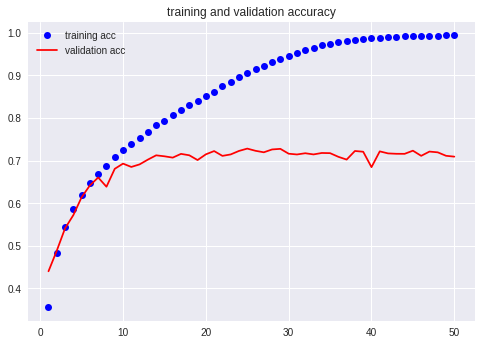

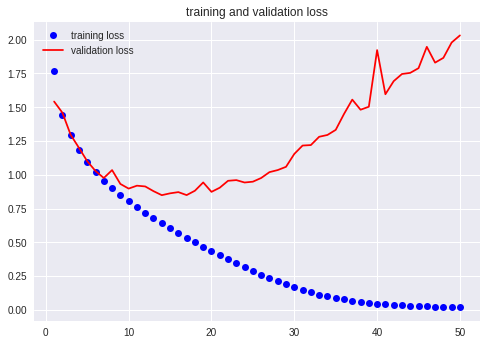

In [0]:
plot_results(history_simple)

## Dropout Model Graphs
This model fairs much better than the previous one, as the training and validation plots keep up with one another, and the accuracy greatly increases.

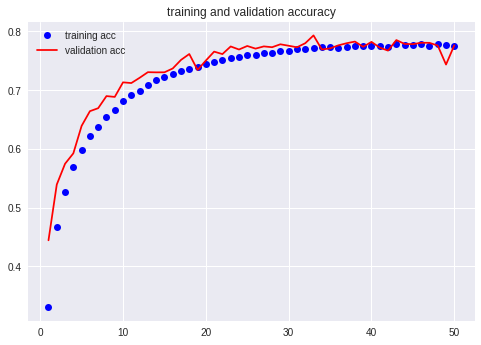

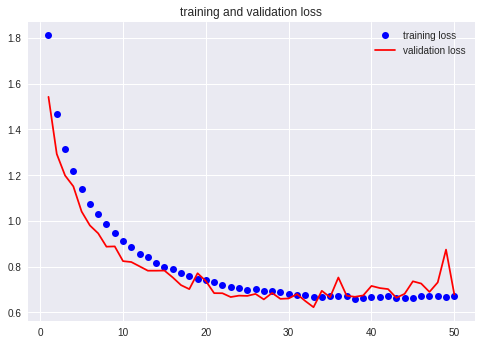

In [0]:
plot_results(history_drop)

## Model with Data Augmentation Graphs

Surprisingly, adding data augmentation to the dropout model not only resulted in a much worse accuracy than without it, but it also caused a severe case of **underfitting**, which means that there are *too many* features and the model cannot dependably categorize which are important and which are not.  However, both graphs show a trend towards improvement, which potentially means, given enough training epochs, the accuracy could plateau at a higher value.  However, the problem of huge underfitting still persists, and it is unlikely the model would reach much higher performance.

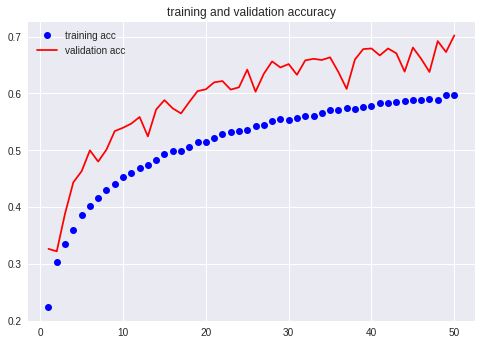

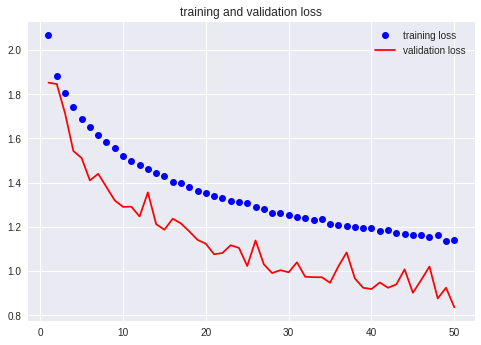

In [0]:
plot_results(history_drop_aug)

## Normalized Model Graphs

This model displays slight overfitting, but at the same achieves an accuracy better than any of the models before it.  This shows how powerful batch normalization can be to creating a good and quickly converging model.

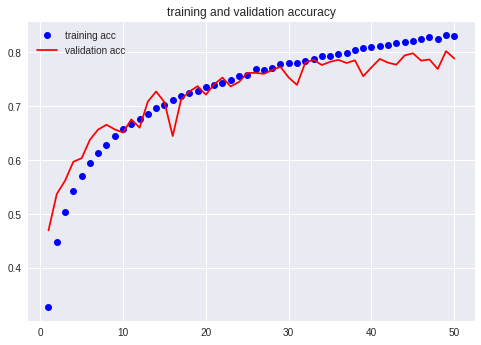

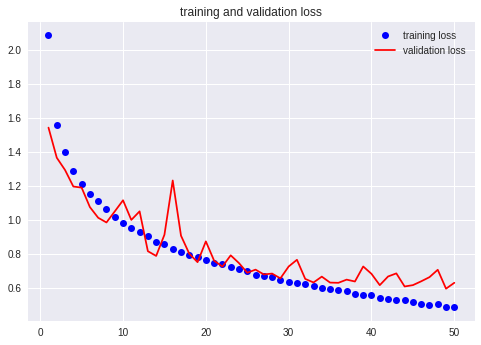

In [0]:
plot_results(history_norm)

##  Show final accuracy for models and train best one on entire original training set

In [0]:
print("Final accuracy for each model: ")
print("Simple Model: %f" % history_simple.history['val_acc'][-1])
print("Dropout Model: %f" % history_drop.history['val_acc'][-1])
print("Augmentation and Dropout Model: %f" % history_drop_aug.history['val_acc'][-1])
print("Batch Normalization Model with Dropout: %f" % history_norm.history['val_acc'][-1])

Final accuracy for each model: 
Simple Model: 0.709300
Dropout Model: 0.776400
Augmentation and Dropout Model: 0.702188
Batch Normalization Model with Dropout: 0.788700


It can be seen that the Batch Normalization Model with Dropout performs the best out of all the models, so we select this one to do final training/testing with.

### Train best model

In [0]:
model_norm.load_weights('weights_norm.h5')
history = model_norm.fit(data_images, 
                      data_labels, 
                      epochs=50,  
                      validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 37s 739us/step - loss: 2.0065 - acc: 0.3464 - val_loss: 1.4845 - val_acc: 0.4911
Epoch 2/50
50000/50000 [==============================] - 34s 682us/step - loss: 1.4988 - acc: 0.4704 - val_loss: 1.4002 - val_acc: 0.5365
Epoch 3/50
50000/50000 [==============================] - 34s 674us/step - loss: 1.3409 - acc: 0.5251 - val_loss: 1.3338 - val_acc: 0.5641
Epoch 4/50
50000/50000 [==============================] - 33s 654us/step - loss: 1.2251 - acc: 0.5679 - val_loss: 1.2618 - val_acc: 0.5857
Epoch 5/50
50000/50000 [==============================] - 33s 654us/step - loss: 1.1567 - acc: 0.5950 - val_loss: 1.0247 - val_acc: 0.6435
Epoch 6/50
50000/50000 [==============================] - 33s 655us/step - loss: 1.0902 - acc: 0.6206 - val_loss: 0.9672 - val_acc: 0.6712
Epoch 7/50
50000/50000 [==============================] - 33s 655us/step - loss: 1.0460 - acc: 0.6363 - val_loss: 0.

A final accuracy of around 78.8% is achieved when this model is fitted with the actual test data, which is pretty much the same as for when it was fitted with the validation set.

## K-fold Cross Validation on best model

In [0]:
# Shuffle the data again to prepare for k-fold CV.
shuffled_i = np.random.permutation(data_size)
data_images = data_images[shuffled_i]
data_labels = data_labels[shuffled_i]

# Declare the size of k as well as how large the validation set
# must be for each fold.
k_fold = 5
val_batch_size = int(data_size/k_fold)

# Keep a running total of the accuracy over each fold.
avg_acc = 0

# Perform k-fold CV.
for i in range(k_fold):
  print("\nTraining, Fold %d:" % (i + 1))
  
  # Find the start and end points in the data set from which
  # to extract the validation set.
  start = i * val_batch_size
  end = i * val_batch_size + val_batch_size
  
  # Get the train/validation images and labels
  train_images = np.concatenate((data_images[:start], data_images[end:]))
  val_images = data_images[start:end]
  
  train_labels = np.concatenate((data_labels[:start], data_labels[end:]))
  val_labels = data_labels[start:end]
  
  # Set the model's weights to before it was trained and train it
  # with the training set and validation set.
  model_norm.load_weights('weights_norm.h5')
  history = model_norm.fit(train_images, 
                      train_labels, 
                      verbose = 2,
                      epochs=50,  
                      validation_data=(val_images, val_labels))
  
  # Record the accuracy on this fold
  avg_acc += history.history['val_acc'][-1]


Training, Fold 1:
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
 - 26s - loss: 2.0877 - acc: 0.3312 - val_loss: 1.5017 - val_acc: 0.4726
Epoch 2/50
 - 25s - loss: 1.5603 - acc: 0.4480 - val_loss: 1.3157 - val_acc: 0.5419
Epoch 3/50
 - 25s - loss: 1.4018 - acc: 0.5014 - val_loss: 1.3683 - val_acc: 0.5489
Epoch 4/50
 - 25s - loss: 1.2928 - acc: 0.5436 - val_loss: 1.1846 - val_acc: 0.5858
Epoch 5/50
 - 25s - loss: 1.2143 - acc: 0.5719 - val_loss: 1.0707 - val_acc: 0.6312
Epoch 6/50
 - 25s - loss: 1.1567 - acc: 0.5948 - val_loss: 1.1764 - val_acc: 0.6242
Epoch 7/50
 - 25s - loss: 1.1063 - acc: 0.6129 - val_loss: 1.2305 - val_acc: 0.6085
Epoch 8/50
 - 25s - loss: 1.0673 - acc: 0.6273 - val_loss: 1.1554 - val_acc: 0.6313
Epoch 9/50
 - 25s - loss: 1.0227 - acc: 0.6428 - val_loss: 1.0172 - val_acc: 0.6584
Epoch 10/50
 - 25s - loss: 0.9856 - acc: 0.6575 - val_loss: 0.9126 - val_acc: 0.6941
Epoch 11/50
 - 25s - loss: 0.9519 - acc: 0.6704 - val_loss: 1.0877 - val_acc: 0.6544
Epoch

In [0]:
print("Final average accuracy with k-fold validation: %f" % (avg_acc/k_fold))

Final average accuracy with k-fold validation: 0.789920


This final average accuracy is ever so slightly higher than when it was just simple hold-out validation, and reflects how the model was able to achieve accuracies above 80% at some epochs.